# Introduction

**Contents:** Produce additional results for the consumption-saving model

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from EconModel import jit
from ConSavModel import ConSavModelClass

# Consumption-Saving Model

In [2]:
model = ConSavModelClass()

In [3]:
par = model.par
sol = model.sol
sim = model.sim
D = sim.D_
Dbeg = sim.Dbeg_

In [4]:
model.solve(algo='egm')
model.prepare_simulate(algo='hist')
model.simulate_hist_alt()

iteration    0 solved in 15.5 secs  [max abs. diff. 4.96e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.35e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.02e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.35e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.39e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.80e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.40e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.12e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.15e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 3.28e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 3.03e-06]
iteration  269 solved in 0.0 secs   [max abs. diff. 9.93e-09]
model solved in 17.9 secs
model prepared for simulation in 0.0 secs
model simulated in 16.4 secs [271 iterations]


## Policy functions

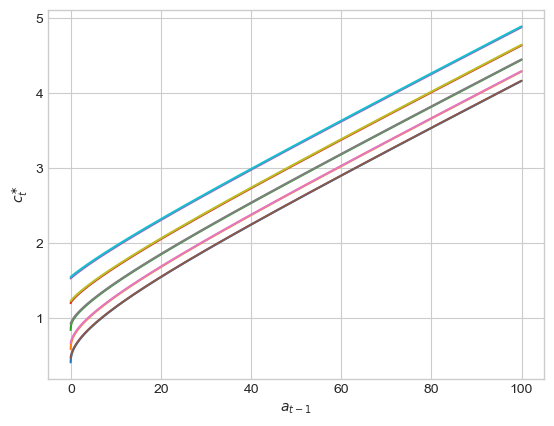

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.c[i_z,:])
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t^{\\ast}$');

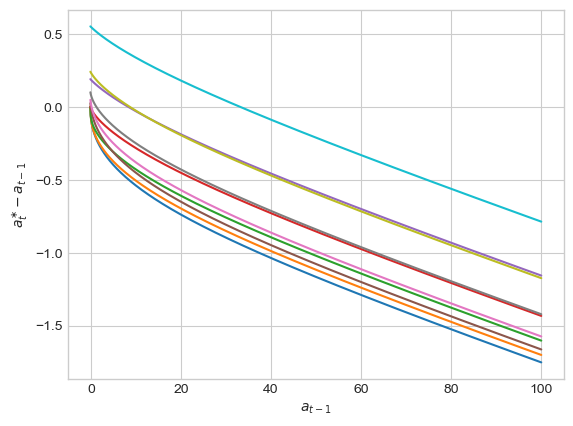

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid)
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

## Savings distribution

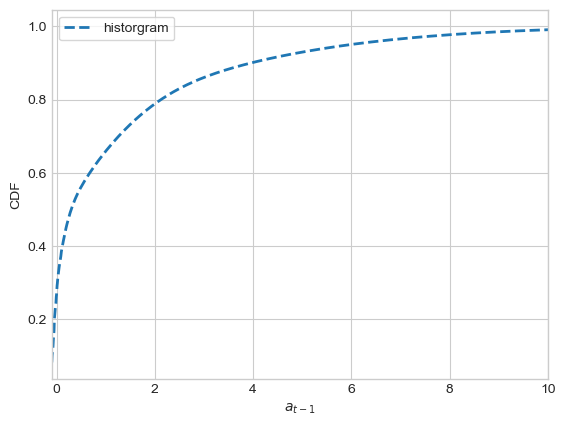

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

CDF = np.cumsum(np.sum(D,axis=(0,)))

ax.plot(par.a_grid,CDF,ls='--',lw=2,label='historgram')

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('CDF')
ax.set_xlim([par.b,10.0])
ax.legend(frameon=True);

**Income moments:**

In [60]:
mean_z = np.sum(D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(D*(par.z_grid[:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.38


**Asset moments**

In [61]:
# a. prepare
Da = np.sum(D,axis=0)
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

print(f'a = par.b: {Da[0]*100:.1f} %')
print(f'a <= 0: {np.sum(Da[par.a_grid <= 0])*100:.1f} %')

mean a:  1.272
p25  a: -0.014
p50  a:  0.298
p95  a:  5.969
p99  a:  9.824
std. a:  2.138
a = par.b: 8.1 %
a <= 0: 27.4 %


## MPCs

**Calculate MPC from consumption function:**

In [62]:
MPC = (sol.c[:,1:]-sol.c[:,:-1])/((1+par.r)*(par.a_grid[1:]-par.a_grid[:-1]))

**Policy function:**

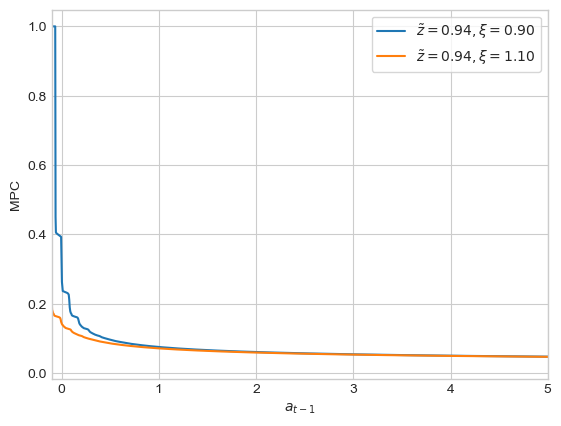

In [63]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i_zt in [par.Nzt//2]:
    for i_xi in [0,par.Nxi-1]:
    
        i_z = i_xi*par.Nzt + i_zt
        label = f'$\\tilde{{z}} = {par.zt_grid[i_zt]:.2f}, \\xi = {par.xi_grid[i_xi]:.2f}$'
        ax.plot(par.a_grid[:-1],MPC[i_z],label=label)

ax.set_xlim([par.b,5])
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('MPC')
ax.legend(frameon=True);

**Mean MPC:**

In [64]:
mean_MPC = np.sum(MPC*D[:,:-1])
print(f'mean MPC: {mean_MPC:6.3f}')

mean MPC:  0.202


**MPC distribution:**

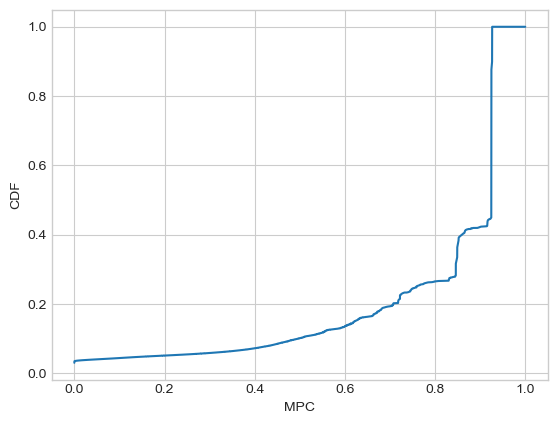

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

I = np.argsort(MPC.ravel())
ax.plot(np.cumsum(D[:,:-1].ravel()[I]),MPC.ravel()[I])

ax.set_xlabel('MPC')
ax.set_ylabel('CDF');

#### Adjust β to target different levels of average wealth

In [66]:
def avg_wealth(beta,model_,do_print=False):
    
    # Adjust beta 
    model = model_.copy()
    model.par.beta= beta
    model.allocate()
    
    
    # Solve and simulate
    model.solve(algo='egm',do_print=do_print)
    model.prepare_simulate(algo='hist',do_print=do_print)
    model.simulate_hist_alt(do_print=do_print)
    
    
    Da = np.sum(model.sim.D_,axis=0)
    mean_a = np.sum(Da*model.par.a_grid)
    return mean_a

In [67]:
avg_wealth(0.96,model)

1.2724054366541568

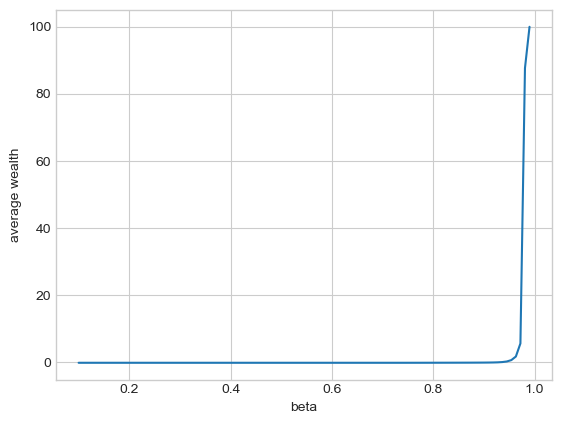

In [68]:
## Plot avg wealth as a func of β
beta_vec = np.linspace(0.1,0.99,100)
avg_wealth_vec = np.empty(beta_vec.shape)

for i, beta in enumerate(beta_vec):
    avg_wealth_vec[i] = avg_wealth(beta,model)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(beta_vec,avg_wealth_vec)

ax.set_xlabel('beta')
ax.set_ylabel('average wealth');

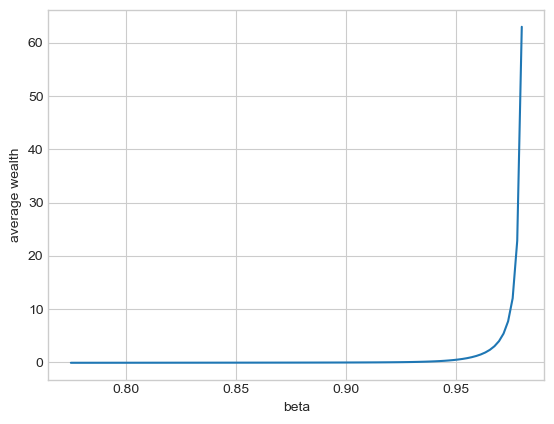

In [69]:
## Plot avg wealth as a func of β
beta_vec = np.linspace(0.775,0.98,100)
avg_wealth_vec = np.empty(beta_vec.shape)

for i, beta in enumerate(beta_vec):
    avg_wealth_vec[i] = avg_wealth(beta,model)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(beta_vec,avg_wealth_vec)

ax.set_xlabel('beta')
ax.set_ylabel('average wealth');

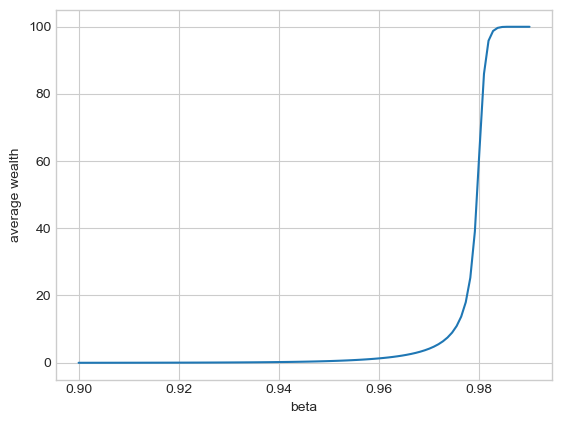

In [70]:
## Plot avg wealth as a func of β
beta_vec = np.linspace(0.9,0.99,100)
avg_wealth_vec = np.empty(beta_vec.shape)

for i, beta in enumerate(beta_vec):
    avg_wealth_vec[i] = avg_wealth(beta,model)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(beta_vec,avg_wealth_vec)

ax.set_xlabel('beta')
ax.set_ylabel('average wealth');
# Due to the grid point stopping at 100

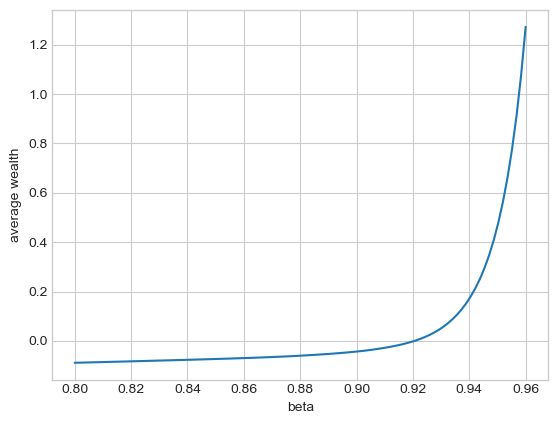

In [71]:
## Plot avg wealth as a func of β
beta_vec = np.linspace(0.8,0.96,100)
avg_wealth_vec = np.empty(beta_vec.shape)

for i, beta in enumerate(beta_vec):
    avg_wealth_vec[i] = avg_wealth(beta,model)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(beta_vec,avg_wealth_vec)

ax.set_xlabel('beta')
ax.set_ylabel('average wealth');

In [72]:
from scipy import optimize


In [73]:
w_levels = [0,1.2724054366541568,10, 20]

w_levels = [0,1.2724054366541568,10, 20]

beta_sol = np.empty(len(w_levels))
model_vec = [model.copy() for i in range(len(w_levels))]

for i, w in enumerate(w_levels):
    
    def obj(beta):
        return avg_wealth(beta,model)-w
    
    beta_sol[i]  = optimize.bisect(obj,0.88,0.98)
    print(f"Solution found for \navg wealth = {w:2.4f} -> beta =  {beta_sol[i]}")
    
    
    model_vec[i].par.beta = beta_sol[i]
    model_vec[i].allocate()
   
    

Solution found for 
avg wealth = 0.0000 -> beta =  0.920469344194571
Solution found for 
avg wealth = 1.2724 -> beta =  0.9600000000002915
Solution found for 
avg wealth = 10.0000 -> beta =  0.9750710629767854
Solution found for 
avg wealth = 20.0000 -> beta =  0.977579315553594


In [74]:
# print average mpc:
do_print =False 
for i, model in enumerate(model_vec):
    print(f'\n\nModel with: \navg wealth = {w_levels[i]:2.4f} -> beta =  {beta_sol[i]} \n')
    
    # Solve and simulate
    model.solve(algo='egm',do_print=do_print)
    model.prepare_simulate(algo='hist',do_print=do_print)
    model.simulate_hist_alt(do_print=do_print)
    
    sol, sim , par= model.sol ,model.sim, model.par
    
    MPC = (sol.c[:,1:]-sol.c[:,:-1])/((1+par.r)*(par.a_grid[1:]-par.a_grid[:-1]))
    mean_MPC = np.sum(MPC*sim.D_[:,:-1])
    print(f'mean MPC: {mean_MPC:6.3f}')



Model with: 
avg wealth = 0.0000 -> beta =  0.920469344194571 

mean MPC:  0.531


Model with: 
avg wealth = 1.2724 -> beta =  0.9600000000002915 

mean MPC:  0.202


Model with: 
avg wealth = 10.0000 -> beta =  0.9750710629767854 

mean MPC:  0.060


Model with: 
avg wealth = 20.0000 -> beta =  0.977579315553594 

mean MPC:  0.037


## Add unemployment risk and unemployment benfits 

Full model before
\begin{align}
v_{t}(z_{t},a_{t-1},\xi_{t}) & =\max_{c_{t}}u(c_{t})+\beta\mathbb{E}_{t}[v_{t+1}(z_{t+1},a_{t},\xi_{t+1})]\\
 & \text{s.t. }\\
 & a_{t}=(1+r)a_{t-1}+wz_{t}\xi_{t}-c_{t}\\
 & \log z_{t+1}=\rho_{z}\,\log z_{t}+\psi_{t+1},\,\,\mathbb{E}[z_{t}]=1,\text{Var}[\psi_{t}]=\sigma_{\psi}^{2}\\
 & \xi_{t} ∼ \exp\left( \text{normal}(0,\sigma_{xi}) \right)
\end{align}

Full model before
\begin{align}
v_{t}(z_{t},a_{t-1},\xi_{t}) & =\max_{c_{t}}u(c_{t})+\beta\mathbb{E}_{t}[v_{t+1}(z_{t+1},a_{t},\xi_{t+1})]\\
 & \text{s.t. }\\
 & a_{t}=(1+r)a_{t-1}+income-c_{t}\\
 & income = \begin{cases}   wz_{t}\xi_{t} , & \text{if employed}_t \\
                            w\cdot\text{benefit}, & \text{if unemployed}_t
            \end{cases} \\
& \text{Transition matrix for employment:} 
            \left[\begin{matrix}
            1-\text{seperation} & \text{seperation} \\
            \text{job\_find}    & 1-\text{job\_find}
            \end{matrix}\right] \\
 & \log z_{t+1}=\rho_{z}\,\log z_{t}+\psi_{t+1},\,\,\mathbb{E}[z_{t}]=1,\text{Var}[\psi_{t}]=\sigma_{\psi}^{2}\\
 & \xi_{t} ∼ \exp\left( \text{normal}(0,\sigma_{xi}) \right)
\end{align}

In [45]:
model_u = ConSavModelClass(par ={'seperation':0.04})
model_u.solve(algo='egm')

iteration    0 solved in 1.5 secs   [max abs. diff. 4.96e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.38e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.04e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.37e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.41e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.81e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.41e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.13e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.24e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 3.50e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 1.26e-05]
iteration  296 solved in 0.0 secs   [max abs. diff. 9.93e-09]
model solved in 2.0 secs


In [46]:
model_u.par.seperation

0.04

In [47]:
model_u.sol.c.shape

(20, 500)

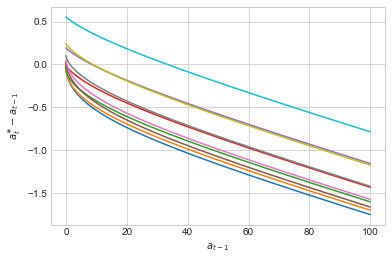

In [48]:
# Policy function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
par, sol = model_u.par, model_u.sol

for i_z in range(par.Nz):
    ax.plot(par.a_grid,sol.a[i_z,:]-par.a_grid)
    
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

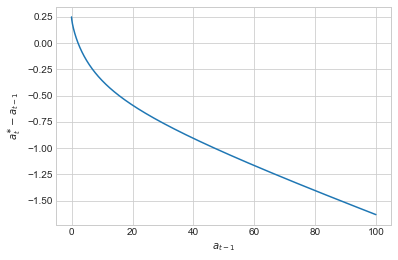

In [51]:
# Policy function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

par, sol = model_u.par, model_u.sol
ax.plot(par.a_grid,np.mean(sol.a,axis=0)-par.a_grid)

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

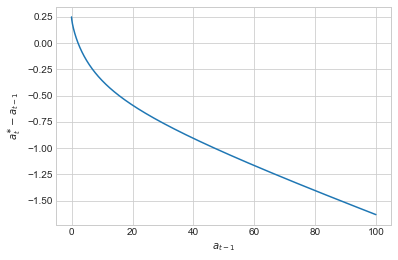

In [52]:
# Policy function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

par, sol = model.par, model_u.sol
ax.plot(par.a_grid,np.mean(sol.a,axis=0)-par.a_grid)

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t^{\\ast}-a_{t-1}$');

In [60]:
print(np.mean(model.sol.a))
print(np.mean(model.sol.c))
print(np.mean(model_u.sol.a))
print(np.mean(model_u.sol.c))

16.13844407600227
1.6672504487553088
16.10375242440827
1.2206271173781083


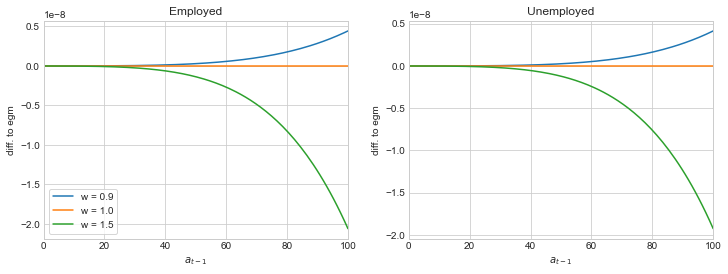

In [63]:
fig = plt.figure(figsize=(12,6/1.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title(f'Employed')
ax2.set_title(f'Unemployed')
par = model_u.par
i_zt = (par.Nzt*par.Nxi)//2

for w,ls in [(0.9,'-'),(1.0,'--'),(1.5,'--')]:
    
    fac = w/par.w
    
    model_ = model_u.copy()
    model_.par.w = w
    model_.par.a_grid[:] = fac*model_.par.a_grid
    model_.solve(do_print=False,algo='egm')
    
    ax1.plot(model_.par.a_grid/fac,model_.sol.c[0*par.Nzt*par.Nxi+i_zt,:]/fac-model_u.sol.c[0*par.Nzt*par.Nxi+i_zt,:],label=f'{w = :.1f}')
    ax2.plot(model_.par.a_grid/fac,model_.sol.c[1*par.Nzt*par.Nxi,:]/fac-model_u.sol.c[1*par.Nzt*par.Nxi+i_zt,:])
             
ax1.legend(frameon=True) 
for ax in [ax1,ax2]:
    ax.set_xlim([0,100])
    ax.set_xlabel('$a_{t-1}$');
    ax.set_ylabel('diff. to egm');

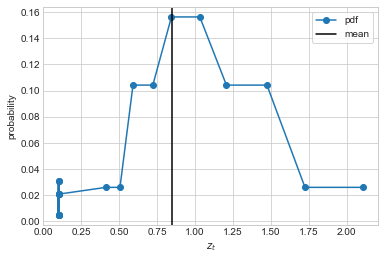

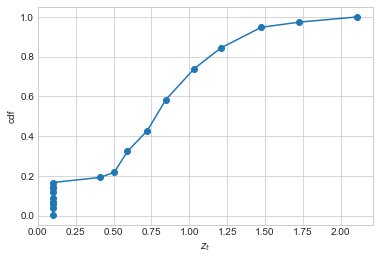

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
par = model_u.par
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],par.z_ergodic[I],'-o',label='pdf')
ax.axvline(np.sum(par.z_ergodic*par.z_grid),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True)
ax.plot();
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
I = np.argsort(par.z_grid)
ax.plot(par.z_grid[I],np.cumsum(par.z_ergodic[I]),'-o')
ax.set_xlabel('$z_t$')
ax.set_ylabel('cdf')
ax.plot();

model prepared for simulation in 0.4 secs
model simulated in 0.9 secs secs


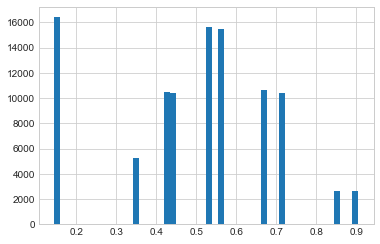

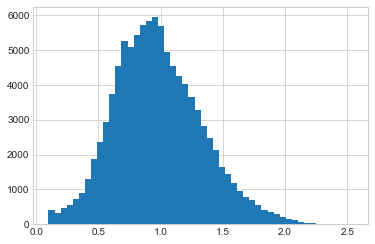

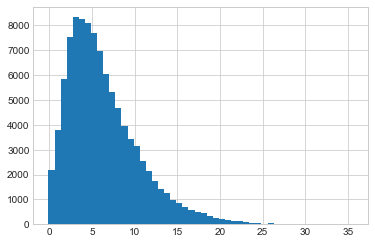

In [112]:
model_u.prepare_simulate(algo='mc')
model_u.simulate(algo='mc')
plt.hist(model_u.sim.c[0,:],bins=50)
plt.show();
plt.hist(model_u.sim.c[-1,:],bins=50)
plt.show();
plt.hist(model_u.sim.a[-1,:],bins=50)
plt.show();

In [98]:
model_u.simulate_hist_alt()

model simulated in 0.0 secs [0 iterations]


In [101]:
model_u.sim.D_.shape

(20, 500)

In [103]:
model_u.sol.a.shape

(20, 500)

In [115]:
np.sum(model_u.sim.D_)

0.9999999956009062

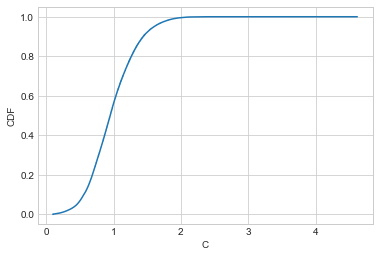

In [118]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

I = np.argsort(model_u.sol.c.ravel())
ax.plot(model_u.sol.c.ravel()[I],np.cumsum(model_u.sim.D_.ravel()[I]))

ax.set_xlabel('C')
ax.set_ylabel('CDF');